# 3. Оператор Кэнни

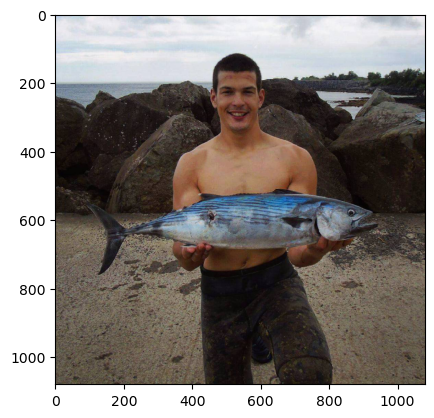

In [1]:
import random
from typing import Union

from PIL import Image
from matplotlib.pyplot import figure, imshow, show
import numpy as np
import numpy.typing as npt

def get_image() -> np.array:
    dir = "images/"
    image = Image.open(dir + "fishman.jpg")
    image_array = np.array(image)[:, :, :3]
    return image_array


def show_image(array: np.array, mode: Union[str, None] = 'Greys'):
    figure()
    imshow(array, cmap=mode)


show_image(get_image())

## Полутоновое изображение

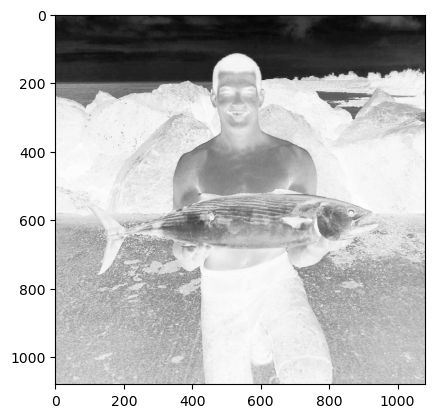

In [2]:
def get_halftone_image() -> np.array:
    image_array = get_image()
    mean = np.mean(image_array, axis=2, dtype=int)
    return mean

show_image(get_halftone_image())

## Шум

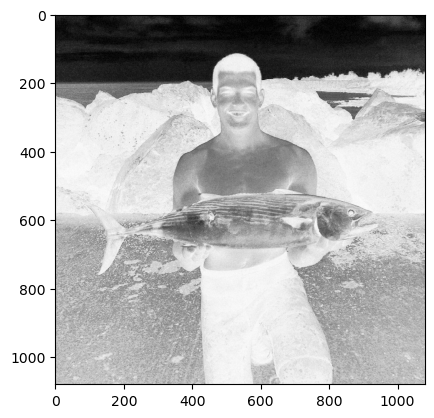

In [3]:
def get_noise_image(mean: float = 50, sigma: float = 5, data_type=float) -> np.array:
    halftone_image_array = get_halftone_image()
    return np.clip(np.array([np.array([pixel + random.gauss(mean, sigma) * random.randint(0, 1) // 3 for pixel in row], dtype=data_type)
                     for row in halftone_image_array]), 0, 255)

show_image(get_noise_image())

## Размытие Гаусса

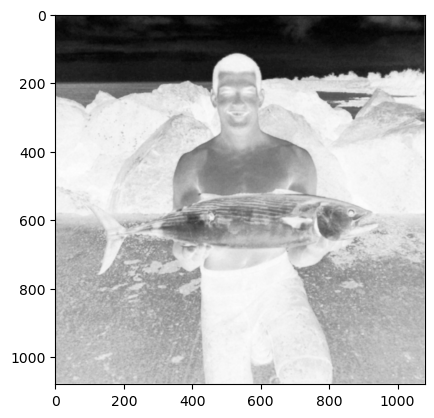

In [4]:
def filter_gauss(K_size, sigma, im):
    H, W = im.shape

    pad = K_size // 2
    out = np.zeros((H + pad * 2, W + pad * 2), np.float64)
    out[pad: pad + H, pad: pad + W] = im.copy().astype(np.float64)

    K = np.zeros((K_size, K_size), np.float64)
    for x in range(-pad, -pad + K_size):
        for y in range(-pad, -pad + K_size):
            K[x + pad, y + pad] = np.exp( -(x * x + y * y) / (2 * (sigma * sigma)))
    K /= 2 * np.pi * sigma * sigma
    K /= K.sum()

    tmp = out.copy()

    for y in range(H):
        for x in range(W):
            out[pad + y, pad + x] = np.sum(K * tmp[y: y + K_size, x: x + K_size])
    out = np.clip(out, 0, 255).astype(np.uint8)
    return out[pad: pad + H, pad: pad + W]

show_image(filter_gauss(8, 1.5, get_noise_image()))

## Фильтр Собеля

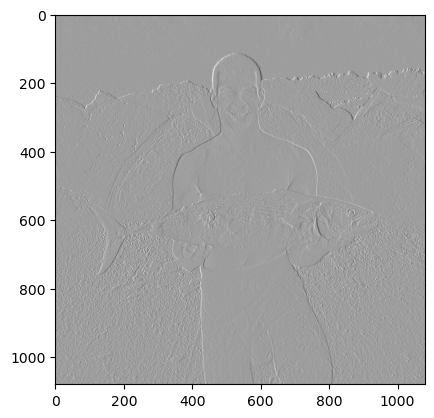

In [5]:
def filter_sobel(image) -> npt.NDArray[list[tuple[int, int]]]:
    H, W = image.shape

    out = np.zeros((H + 2, W + 2, 2), np.float64)
    out[1: 1 + H, 1: 1 + W, 0] = image.copy().astype(np.float64)
    out[0, 0, 0] = out[1, 1, 0]
    out[-1, 0, 0] = out[-2, 1, 0]
    out[0, -1, 0] = out[1, -2, 0]
    out[-1, -1, 0] = out[-2, -2, 0]
    out[1: 1 + H, 0, 0] = out[1: 1 + H, 1, 0]
    out[1: 1 + H, -1, 0] = out[1: 1 + H, -2, 0]
    out[0, 1: 1 + W, 0] = out[1, 1: 1 + W, 0]
    out[-1, 1: 1 + W, 0] = out[-2, 1: 1 + W, 0]

    Mx = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]],
        dtype=int
    )
    My = np.array([
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]
    ],
        dtype=int
    )
    tmp = out.copy()

    for y in range(H):
        for x in range(W):
            out[1 + y, 1 + x] = (np.sum(Mx * tmp[y: y + 3, x: x + 3, 0]), np.sum(My * tmp[y: y + 3, x: x + 3, 0]))
    return out[1: 1 + H, 1: 1 + W]


show_image(filter_sobel(get_halftone_image())[:, :, 0])

## Нахождение магнитуд и направлений

In [6]:
def get_magnitude(gradient_matrix: npt.NDArray) -> npt.NDArray[list[int]]:
    return np.sum(abs(gradient_matrix), axis=2)

def get_direction_degrees(gradient_matrix: npt.NDArray) -> npt.NDArray[list[float]]:
    return np.degrees(np.arctan2(gradient_matrix[:, :, 1], gradient_matrix[:, :, 0]))

def get_direction_in_45_step(gradient_matrix: npt.NDArray) -> npt.NDArray[list[int]]:
    degrees_matrix = get_direction_degrees(gradient_matrix)
    return np.rint(degrees_matrix % 360 / 45).astype(int) * 45

image = filter_gauss(8, 1, get_noise_image())
# image = get_halftone_image()
gradient_matrix = filter_sobel(image)
magnitude = get_magnitude(gradient_matrix)
direction = get_direction_in_45_step(gradient_matrix)

## Подавление максимумов

In [7]:
def _get_directions(current_angle: int, i: int, j: int) -> tuple[tuple[int, int], tuple[int, int]]:
        if current_angle in (0, 180, 360):
                return (i, j + 1), (i, j - 1)
        elif current_angle in (45, 225):
                return (i - 1, j + 1), (i + 1, j - 1)
        elif current_angle in (90, 270):
                return (i - 1, j), (i + 1, j)
        elif current_angle in (135, 315):
                return (i - 1, j - 1), (i + 1, j + 1)
        else:
            raise Exception


def maximum_suppression(magnitude: npt.NDArray[list[float]], direction: npt.NDArray[list[int]]):
    H, W = magnitude.shape

    for i in range(H):
        for j in range(W):
            if not magnitude[i][j]:
                continue
            directions = _get_directions(direction[i][j], i, j)
            if directions[0][0] < 0 or directions[0][0] == H or directions[0][1] < 0 or directions[0][1] == W:
                point_1_magnitude = 0
            else:
                point_1_magnitude = magnitude[directions[0][0]][directions[0][1]]
            if directions[1][0] < 0 or directions[1][0] == H or directions[1][1] < 0 or directions[1][1] == W:
                point_2_magnitude = 0
            else:
                point_2_magnitude = magnitude[directions[1][0]][directions[1][1]]
            if not (magnitude[i][j] > point_1_magnitude and magnitude[i][j] > point_2_magnitude):
                magnitude[i][j] = 0

maximum_suppression(magnitude, direction)

## Оператор Кэнни

In [8]:
def kenny_operator(suppressed_magnitude: npt.NDArray[list[float]]):
    Thigh, Tlow = 200, 100
    H, W = suppressed_magnitude.shape

    borders = np.zeros((H + 2, W + 2), bool)
    magnitude = borders.copy().astype(float)
    magnitude[1: 1 + H, 1: 1 + W] = suppressed_magnitude

    for i in range(H):
        for j in range(W):
            if suppressed_magnitude[i][j] <= Thigh or borders[i + 1, j + 1]:
                continue
            borders[i + 1, j + 1] = True
            temp_i, temp_j = i, j
            while True:
                temp_border = (magnitude[temp_i: temp_i + 3, temp_j: temp_j + 3] > Tlow) ^ borders[temp_i: temp_i + 3, temp_j: temp_j + 3]
                if temp_border.any():
                    temp_i += np.argwhere(temp_border)[-1][0] - 1
                    temp_j += np.argwhere(temp_border)[-1][1] - 1
                    borders[temp_i + 1, temp_j + 1] = True
                else:
                    break
    return borders[1: H + 1, 1: W + 1].astype(np.bool_)


image_after_kenny_operator = kenny_operator(magnitude)

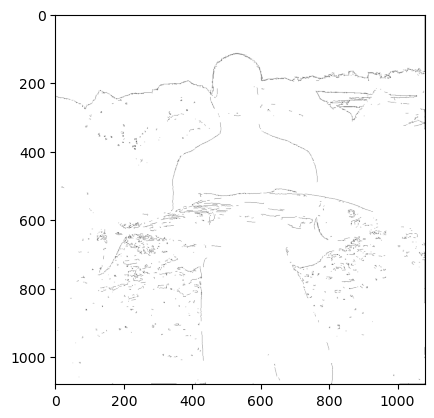

In [9]:
show_image(image_after_kenny_operator)